In [183]:
%matplotlib inline
import torch
from torchvision import transforms
from torch.utils import data
import h5py
import numpy as np
import abel
import numba
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
h5_file = h5py.File('../../data/raw/ion_images.h5', 'r')

In [3]:
test_image = h5_file["true"][5016]

In [129]:
class ProcessNumpyArray(object):
    def __call__(self, X: np.ndarray):
        if X.dtype != np.uint8:
            X_max = X.max()
            X /= X_max
            X *= 255
            X = X.astype(np.uint8)
        return X[:,:,np.newaxis]


class AbelProjection(object):
    def __call__(self, X: np.ndarray) -> np.ndarray:
        try:
            return abel.Transform(X, direction='forward', method='hansenlaw').transform
        except ValueError as error:
            print(f"{error} - {X.shape}")

@numba.njit
def cart2r(x, y):
    r = np.sqrt(x**2 + y**2)
    return r


@numba.njit
def radial_integration(image: np.ndarray):
    h, w = image.shape
    center = (h + w) // 4
    r_bins = np.zeros(center)
    for x in range(center):
        for y in range(center):
            r = np.int(cart2r(x, y))
            if r < center:
                r_bins[r] += image[x+center, y+center]
    hist_max = r_bins.max()
    return r_bins / hist_max

In [130]:
ra = transforms.RandomAffine(0., translate=(0.05, 0.05), scale=(0.3, 1.))

In [131]:
pipeline = transforms.Compose([AbelProjection(), ProcessNumpyArray(), transforms.ToPILImage(), ra, transforms.ToTensor()])

## Integrated radial profile

We can check that everything looks more or less correct by integrating along the distance from the image center:

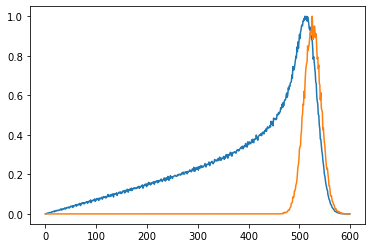

In [175]:
plt.plot(radial_integration(AbelProjection()(test_image)))
plt.plot(radial_integration(test_image))

## Dataset class

We need a Dataset class that will synthesize a new image from the HDF5 data each time `__getitem__` is called, from a combination of _n_ possible images.

In [190]:
class H5Dataset(data.Dataset):
    def __init__(self, path: str, key: str, transform=None):
        self.file_path = path
        self.key = key
        self.dataset = None
        self.transform = transform
        with h5py.File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.key])

    def __getitem__(self, index):
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')[self.key]
        X = self.dataset[index]
        if self.transform:
            return self.transform(X)
        return X

    def __len__(self):
        return self.dataset_len


class CompositeH5Dataset(H5Dataset):
    def __init__(self, path: str, key: str, transform=None, scale: float = 2., seed=None):
        super().__init__(path, key, transform)
        self.seed = seed
        self.scale = scale
        self.indices = np.arange(len(self))

    def __getitem__(self, index):
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')[self.key]
        n_composites = int(np.random.exponential(self.scale) + 1)
        chosen = np.random.choice(self.indices, size=n_composites)
        if n_composites != 1:
            chosen.sort()
        X = self.dataset[chosen]
        # if we have multiple images, flatten to a single composite
        if X.ndim == 3:
            X = X.sum(axis=0)
        # if we have a compose pipeline defined, run it
        if self.transform:
            return (self.transform(X), X)
        return (X, None)

    
class SelectiveComposite(H5Dataset):
    def __init__(self, path: str, key: str, transform=None):
        super().__init__(path, key, transform)

    def __getitem__(self, indices):
        if self.dataset is None:
            self.dataset = h5py.File(self.file_path, 'r')[self.key]
        indices = sorted(indices)
        X = self.dataset[indices].sum(axis=0).astype(float)
        if self.transform:
            return (self.transform(X), torch.FloatTensor(X).unsqueeze(0))
        X = torch.FloatTensor(X).unsqueeze(0)
        return (X, X)

In [102]:
h5_dataset = H5Dataset("../../data/raw/ion_images.h5", "true")

In [168]:
h5_dataset = CompositeH5Dataset("../../data/raw/ion_images.h5", "true", transform=pipeline)

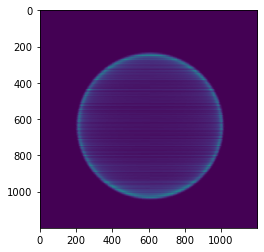

In [174]:
plt.imshow(h5_dataset.__getitem__(0)[0][0])

In [192]:
h5_dataset = SelectiveComposite("../../data/raw/ion_images.h5", "true", transform=pipeline)

In [195]:
h5_dataset.__getitem__([0, 1, 2, 3])[0].dtype

torch.float32